# NDS-GNN Comprehensive Evaluation: CSL Expressiveness + Benchmark Classification

This notebook demonstrates **Nonlinear Diffusion Signatures (NDS)** as parameter-free preprocessing for Graph Neural Networks.

- **Part A**: Tests NDS distinguishing power on CSL (Circular Skip Link) graph classes — measuring which NDS configurations can separate graph isomorphism classes that 1-WL cannot.
- **Part B**: Trains GIN (Graph Isomorphism Network) + NDS on MUTAG with 10-fold cross-validation, comparing vanilla GIN against various NDS augmentation strategies.

NDS interleaves linear graph diffusion with fixed pointwise nonlinearities (ReLU, tanh, etc.) to break spectral invariance.

In [1]:
import subprocess, sys
def _pip(*a): subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', *a])

# loguru — NOT on Colab, always install
_pip('loguru==0.7.3')

# numpy, scipy, torch, matplotlib — pre-installed on Colab, install locally only
if 'google.colab' not in sys.modules:
    _pip('numpy==2.0.2', 'scipy==1.15.3', 'matplotlib==3.10.0')
    _pip('torch==2.6.0+cpu', '--index-url', 'https://download.pytorch.org/whl/cpu')


[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python3.12 -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python3.12 -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python3.12 -m pip install --upgrade pip


In [2]:
import json, os, sys, time
from collections import defaultdict
from pathlib import Path
from typing import Callable, Optional
import numpy as np
import scipy.sparse as sp
import torch
import torch.nn as nn
import torch.nn.functional as F
from loguru import logger
import matplotlib.pyplot as plt

logger.remove()
logger.add(sys.stdout, level="INFO", format="{time:HH:mm:ss}|{level:<7}|{message}")
SEED = 42; np.random.seed(SEED); torch.manual_seed(SEED)

In [3]:
GITHUB_DATA_URL = "https://raw.githubusercontent.com/AMGrobelnik/ai-invention-7ff1bb-nonlinear-diffusion-signatures-breaking-/main/experiment_iter3_nds_gnn_compreh/demo/mini_demo_data.json"

def load_data():
    try:
        import urllib.request
        with urllib.request.urlopen(GITHUB_DATA_URL) as response:
            return json.loads(response.read().decode())
    except Exception: pass
    if os.path.exists("mini_demo_data.json"):
        with open("mini_demo_data.json") as f: return json.load(f)
    raise FileNotFoundError("Could not load mini_demo_data.json")

In [4]:
data = load_data()
dbn = {ds["dataset"]: ds["examples"] for ds in data["datasets"]}
for name, exs in dbn.items():
    print(f"  {name}: {len(exs)} examples")

  CSL: 20 examples
  MUTAG: 60 examples


## Configuration

All tunable parameters are defined here. Adjust to trade off runtime vs. result quality.

In [5]:
# ── Part A: NDS diffusion steps ──
NDS_T_VALUES = [5, 10]           # Original: [5, 10, 15, 20]
WL_ITERS = 10                    # Original: 10

# ── Part B: GIN training ──
MUTAG_EPOCHS = 80                # Original: 80
MUTAG_HIDDEN_DIM = 64            # Original: 64
MUTAG_NUM_LAYERS = 2             # Original: 3
MUTAG_DROPOUT = 0.5              # Original: 0.5
MUTAG_LR = 0.01                  # Original: 0.01
MUTAG_BATCH_SIZE = 32            # Original: 32
MUTAG_PATIENCE = 15              # Original: 15
MUTAG_FOLD_TIME_LIMIT = 25       # Original: 60
NUM_FOLDS = 3                    # Original: 10 (use first 3 for speed)

# ── Methods to evaluate (subset for demo) ──
# Original: all 6. Demo uses 3 key methods: vanilla baseline + 2 NDS variants.
DEMO_METHODS = ["gin_vanilla", "gin_nds_tanh_T10", "gin_nds_relu_T10"]

# ── General ──
MAX_EXAMPLES = None              # Original: None (use all)
TIME_BUDGET = 280                # seconds (5 min with safety margin)
T0 = time.time()

## Graph Utilities

Core functions for parsing graphs, building adjacency matrices, and computing NDS features.

In [6]:
def parse_g(ex):
    gd = json.loads(ex["input"]); n=gd["num_nodes"]
    nf = gd.get("node_features")
    return {"n":n,"el":gd["edge_list"],
            "feat":np.array(nf,dtype=np.float32) if nf else np.ones((n,1),dtype=np.float32),
            "label":int(ex["output"]),"fold":ex.get("metadata_fold",0),
            "ncls":ex.get("metadata_n_classes",2)}

def build_adj(n, el):
    if not el: return sp.csr_matrix((n,n),dtype=np.float32)
    e=np.array(el,dtype=np.int64)
    A=sp.csr_matrix((np.ones(len(e),dtype=np.float32),(e[:,0],e[:,1])),shape=(n,n))
    A=A+A.T; A.data=np.minimum(A.data,1.0); return A

def sym_norm(A):
    deg=np.array(A.sum(1)).flatten(); di=np.zeros_like(deg)
    m=deg>0; di[m]=1.0/np.sqrt(deg[m]); return sp.diags(di)@A@sp.diags(di)

# ═══ NDS Features ═══
def nds(An, x0, nl, T):
    parts=[x0.copy()]; x=x0.copy()
    for _ in range(T): x=nl(An@x); parts.append(x.copy())
    return np.concatenate(parts, axis=1)

def deg_feat(A): return np.array(A.sum(1),dtype=np.float32).reshape(-1,1)

def clust_coeff(A):
    n=A.shape[0]; cc=np.zeros(n,dtype=np.float32); Ac=A.tocsr()
    for v in range(n):
        nb=Ac[v].indices; k=len(nb)
        if k<2: continue
        cc[v]=Ac[nb][:,nb].nnz/(k*(k-1))
    return cc.reshape(-1,1)

def ifeat(A, s):
    if s=="degree": return deg_feat(A)
    if s=="clust": return clust_coeff(A)
    if s=="deg+clust": return np.concatenate([deg_feat(A),clust_coeff(A)],axis=1)
    raise ValueError(s)

_relu=lambda x:np.maximum(x,0.0)
_tanh=lambda x:np.tanh(x)
_abs=lambda x:np.abs(x)
_lrelu=lambda x:np.where(x>0,x,0.2*x)
_id=lambda x:x
NL={"relu":_relu,"tanh":_tanh,"abs":_abs,"leaky_relu":_lrelu,"identity":_id}

# ═══ 1-WL ═══
def wl_hash(A, iters=10):
    n=A.shape[0]; Ac=A.tocsr()
    c=np.array(A.sum(1),dtype=np.int32).flatten().tolist()
    for _ in range(iters):
        cm,ni,nc={},0,[]
        for v in range(n):
            k=(c[v],tuple(sorted(c[u] for u in Ac[v].indices)))
            if k not in cm: cm[k]=ni; ni+=1
            nc.append(cm[k])
        c=nc
    return str(tuple(sorted(c)))

## Part A: CSL Expressiveness Test

Tests whether NDS features can distinguish CSL graph classes that are indistinguishable by the 1-WL test. Each configuration computes graph-level NDS embeddings and checks how many class pairs have distinct centroids.

In [7]:
def part_a(graphs, labels):
    t0=time.time(); n=len(graphs)
    logger.info(f"Part A: CSL — {n} graphs")
    adjs=[build_adj(g["n"],g["el"]) for g in graphs]
    norms=[sym_norm(A) for A in adjs]
    # Build configs using NDS_T_VALUES from config cell
    cfgs = []
    for T in NDS_T_VALUES:
        cfgs.append((f"nds_relu_T{T}_deg","relu",T,"degree"))
        cfgs.append((f"nds_tanh_T{T}_deg","tanh",T,"degree"))
    cfgs.append(("nds_abs_T10_deg","abs",10,"degree"))
    cfgs.append(("nds_lrelu_T10_deg","leaky_relu",10,"degree"))
    cfgs.append(("linear_T10_deg","identity",10,"degree"))
    cfgs.append(("nds_tanh_T10_clust","tanh",10,"clust"))
    cfgs.append(("nds_tanh_T10_dc","tanh",10,"deg+clust"))
    ulabs=sorted(set(labels)); nc=len(ulabs)
    logger.info(f"  {nc} classes")
    scores={}
    for name,nln,T,ini in cfgs:
        gf=[]
        for i in range(n):
            f0=ifeat(adjs[i],ini); nd=nds(norms[i],f0,NL[nln],T)
            gf.append(np.concatenate([np.sort(nd.sum(0)),np.sort(nd.mean(0)),np.sort(nd.std(0))]))
        lf=defaultdict(list)
        for f,l in zip(gf,labels): lf[l].append(f)
        cm={l:np.mean(fs,axis=0) for l,fs in lf.items()}
        np_,nd_=0,0
        for i in range(len(ulabs)):
            for j in range(i+1,len(ulabs)):
                np_+=1
                if np.linalg.norm(cm[ulabs[i]]-cm[ulabs[j]])>1e-6: nd_+=1
        acc=nd_/max(np_,1); scores[name]={"pairs_distinguished":nd_,"total_pairs":np_,"accuracy":acc}
        logger.info(f"  {name}: {nd_}/{np_} ({100*acc:.1f}%)")
    # WL baseline
    wh=[wl_hash(adjs[i], iters=WL_ITERS) for i in range(n)]
    wlh=defaultdict(set)
    for h,l in zip(wh,labels): wlh[l].add(h)
    wn=wd=0
    for i in range(len(ulabs)):
        for j in range(i+1,len(ulabs)):
            wn+=1
            if wlh[ulabs[i]].isdisjoint(wlh[ulabs[j]]): wd+=1
    scores["wl_1_baseline"]={"pairs_distinguished":wd,"total_pairs":wn,"accuracy":wd/max(wn,1)}
    logger.info(f"  wl_1: {wd}/{wn}")
    # Degree baseline
    df=[np.concatenate([np.sort(deg_feat(adjs[i]).flatten()),[deg_feat(adjs[i]).mean(),deg_feat(adjs[i]).std()]]) for i in range(n)]
    dl=defaultdict(list)
    for f,l in zip(df,labels): dl[l].append(f)
    dcm={l:np.mean(fs,axis=0) for l,fs in dl.items()}
    dd=0
    for i in range(len(ulabs)):
        for j in range(i+1,len(ulabs)):
            if np.linalg.norm(dcm[ulabs[i]]-dcm[ulabs[j]])>1e-6: dd+=1
    scores["degree_only"]={"pairs_distinguished":dd,"total_pairs":wn,"accuracy":dd/max(wn,1)}
    logger.info(f"  deg: {dd}/{wn}")
    el=time.time()-t0; logger.info(f"  Part A: {el:.1f}s")
    return {"config_scores":scores,"n_graphs":n,"n_classes":nc,"wall_clock_s":el}

# Run Part A
csl_r = None
if "CSL" in dbn:
    gs = [parse_g(e) for e in dbn["CSL"]]
    if MAX_EXAMPLES: gs = gs[:MAX_EXAMPLES]
    csl_r = part_a(gs, [g["label"] for g in gs])

01:24:59|INFO   |Part A: CSL — 20 graphs


01:24:59|INFO   |  10 classes


01:24:59|INFO   |  nds_relu_T5_deg: 0/45 (0.0%)


01:24:59|INFO   |  nds_tanh_T5_deg: 0/45 (0.0%)


01:24:59|INFO   |  nds_relu_T10_deg: 0/45 (0.0%)


01:24:59|INFO   |  nds_tanh_T10_deg: 0/45 (0.0%)


01:24:59|INFO   |  nds_abs_T10_deg: 0/45 (0.0%)


01:24:59|INFO   |  nds_lrelu_T10_deg: 0/45 (0.0%)


01:25:00|INFO   |  linear_T10_deg: 0/45 (0.0%)


01:25:00|INFO   |  nds_tanh_T10_clust: 9/45 (20.0%)


01:25:00|INFO   |  nds_tanh_T10_dc: 9/45 (20.0%)


01:25:02|INFO   |  wl_1: 0/45


01:25:02|INFO   |  deg: 0/45


01:25:02|INFO   |  Part A: 2.2s


## GIN Model

Graph Isomorphism Network (GIN) with multi-layer perceptron aggregation and graph-level readout via sum/mean pooling across all layers.

In [8]:
class GINLayer(nn.Module):
    def __init__(s,di,do):
        super().__init__(); s.eps=nn.Parameter(torch.zeros(1))
        s.mlp=nn.Sequential(nn.Linear(di,do),nn.BatchNorm1d(do),nn.ReLU(),nn.Linear(do,do),nn.BatchNorm1d(do),nn.ReLU())
    def forward(s,x,a): return s.mlp((1+s.eps)*x+torch.sparse.mm(a,x))

class GIN(nn.Module):
    def __init__(s,di,dh,nc,nl=3,dr=0.5,pool="sum"):
        super().__init__(); s.pool=pool; s.dr=dr
        s.layers=nn.ModuleList([GINLayer(di,dh)]+[GINLayer(dh,dh) for _ in range(nl-1)])
        s.clfs=nn.ModuleList([nn.Linear(di,nc)]+[nn.Linear(dh,nc) for _ in range(nl)])
    def forward(s,x,a,gi,ng):
        hs=[x]; h=x
        for ly in s.layers: h=ly(h,a); hs.append(h)
        logits=torch.zeros(ng,s.clfs[0].out_features)
        for i,(hl,cl) in enumerate(zip(hs,s.clfs)):
            p=torch.zeros(ng,hl.shape[1]); p.scatter_add_(0,gi.unsqueeze(1).expand_as(hl),hl)
            if s.pool=="mean":
                cnt=torch.zeros(ng); cnt.scatter_add_(0,gi,torch.ones(x.shape[0]))
                p=p/cnt.clamp(min=1).unsqueeze(1)
            if i==len(hs)-1: p=F.dropout(p,p=s.dr,training=s.training)
            logits=logits+cl(p)
        return logits

## Pre-batching and Training

Pre-builds all mini-batches per fold for efficient training. Each fold gets pre-batched tensors to avoid repeated graph construction during training.

In [9]:
def prebatch_fold(graphs, feats, train_idx, test_idx, bs=32):
    """Pre-build ALL train batches + test batch as tensors ONCE."""
    def _build(idx):
        tn=0; rows,cols,fps,gis,labs=[],[],[],[],[]
        for li,ii in enumerate(idx):
            g=graphs[ii]; ea=g["el"]
            for s,d in ea: rows.append(s+tn); cols.append(d+tn)
            fps.append(feats[ii]); gis.extend([li]*g["n"]); labs.append(g["label"]); tn+=g["n"]
        x=torch.from_numpy(np.vstack(fps))
        if rows:
            r,c=np.array(rows,dtype=np.int64),np.array(cols,dtype=np.int64)
            a=torch.sparse_coo_tensor(torch.from_numpy(np.stack([r,c])),torch.ones(len(r)),size=(tn,tn))
        else:
            a=torch.sparse_coo_tensor(torch.zeros(2,0,dtype=torch.long),torch.zeros(0),size=(max(tn,1),max(tn,1)))
        return x,a,torch.tensor(gis,dtype=torch.long),torch.tensor(labs,dtype=torch.long),len(idx)
    nt=len(train_idx)
    train_batches=[]
    for s in range(0,nt,bs):
        bi=train_idx[s:min(s+bs,nt)]
        train_batches.append(_build(bi))
    test_batch=_build(test_idx)
    return train_batches, test_batch

def train_fold(graphs, feats, train_idx, test_idx, ncls, dh=64, nl=3, dr=0.5, lr=0.01, ep=100, pat=20, bs=32, pool="sum", time_limit=120):
    """Train GIN on one fold with pre-batching for speed."""
    t0f=time.time()
    di=feats[train_idx[0]].shape[1]
    model=GIN(di,dh,ncls,nl,dr,pool)
    opt=torch.optim.Adam(model.parameters(),lr=lr)
    sch=torch.optim.lr_scheduler.ReduceLROnPlateau(opt,factor=0.5,patience=10)
    train_batches, (x_te,a_te,gi_te,y_te,n_te) = prebatch_fold(graphs,feats,train_idx,test_idx,bs)
    nb=len(train_batches)
    ba,bp,stale=0.0,None,0
    for e in range(ep):
        if time.time()-t0f > time_limit: break
        model.train()
        perm=np.random.permutation(nb)
        tl=0.0; tn=0
        for bi in perm:
            x,a,gi,y,ng=train_batches[bi]
            opt.zero_grad()
            l=F.cross_entropy(model(x,a,gi,ng),y)
            l.backward(); opt.step()
            tl+=l.item()*ng; tn+=ng
        sch.step(tl/max(tn,1))
        model.eval()
        with torch.no_grad():
            p=model(x_te,a_te,gi_te,n_te).argmax(1).numpy()
            ac=float((p==y_te.numpy()).mean())
        if ac>ba: ba,bp,stale=ac,p.copy(),0
        else: stale+=1
        if stale>=pat: break
    return ba,bp

## Feature Augmentation and Part B Execution

Computes NDS-augmented features for each method variant, then runs 10-fold cross-validation on MUTAG.

In [10]:
ALL_METHODS=["gin_vanilla","gin_degree","gin_linear_diff","gin_nds_relu_T10","gin_nds_tanh_T10","gin_nds_tanh_T10_clust"]

def make_features(graphs, adjs, norms, methods):
    mf={}
    for mn in methods:
        if mn=="gin_vanilla": mf[mn]=[g["feat"] for g in graphs]
        elif mn=="gin_degree": mf[mn]=[np.concatenate([g["feat"],deg_feat(adjs[i])],axis=1) for i,g in enumerate(graphs)]
        elif mn=="gin_linear_diff": mf[mn]=[np.concatenate([g["feat"],nds(norms[i],ifeat(adjs[i],"degree"),_id,10)],axis=1) for i,g in enumerate(graphs)]
        elif mn=="gin_nds_relu_T10": mf[mn]=[np.concatenate([g["feat"],nds(norms[i],ifeat(adjs[i],"degree"),_relu,10)],axis=1) for i,g in enumerate(graphs)]
        elif mn=="gin_nds_tanh_T10": mf[mn]=[np.concatenate([g["feat"],nds(norms[i],ifeat(adjs[i],"degree"),_tanh,10)],axis=1) for i,g in enumerate(graphs)]
        elif mn=="gin_nds_tanh_T10_clust": mf[mn]=[np.concatenate([g["feat"],nds(norms[i],ifeat(adjs[i],"deg+clust"),_tanh,10)],axis=1) for i,g in enumerate(graphs)]
    return mf

def part_b(ds_name, examples, max_ex=None, ep=100, dh=64, nl=3, dr=0.5, lr=0.01, bs=32, pat=20, tl=120, n_folds=10, methods=None):
    t0=time.time()
    if methods is None: methods = ALL_METHODS
    graphs=[parse_g(ex) for ex in examples]
    if max_ex and max_ex<len(graphs): graphs=graphs[:max_ex]; examples=examples[:max_ex]
    ng=len(graphs); folds=np.array([g["fold"] for g in graphs])
    ncls=graphs[0]["ncls"]; nfolds_data=int(examples[0].get("metadata_num_folds",10))
    pool="mean" if "IMDB" in ds_name else "sum"
    logger.info(f"{ds_name}: {ng}g, {ncls}cls, {n_folds}f (of {nfolds_data}), pool={pool}")
    adjs=[build_adj(g["n"],g["el"]) for g in graphs]
    norms=[sym_norm(A) for A in adjs]
    logger.info("  Computing features..."); tf=time.time()
    mf=make_features(graphs,adjs,norms,methods)
    logger.info(f"  Features in {time.time()-tf:.1f}s")
    for mn,fs in mf.items(): logger.info(f"    {mn}: dim={fs[0].shape[1]}")
    ufs=sorted(set(folds.tolist()))[:n_folds]  # Use only first n_folds
    logger.info(f"  Folds: {ufs}")
    mr={}; tleft = lambda: TIME_BUDGET - (time.time() - T0)

    for mn in methods:
        if tleft()<20:
            logger.warning(f"  Budget low, skip {mn}")
            mr[mn]={"mean_acc":0,"std_acc":0,"fold_accs":[],"n_folds":0}; continue
        fas=[]; t_m=time.time()
        for fid in ufs:
            if tleft()<10: break
            tri=np.where(folds!=fid)[0]; tei=np.where(folds==fid)[0]
            if not len(tei) or not len(tri): continue
            ac,pr=train_fold(graphs,mf[mn],tri,tei,ncls=ncls,dh=dh,nl=nl,dr=dr,lr=lr,ep=ep,pat=pat,bs=bs,pool=pool,time_limit=tl)
            fas.append(ac)
        ma=float(np.mean(fas)) if fas else 0.0
        sa=float(np.std(fas)) if fas else 0.0
        mr[mn]={"mean_acc":ma,"std_acc":sa,"fold_accs":[float(a) for a in fas],"n_folds":len(fas)}
        logger.info(f"  {mn}: {100*ma:.1f}±{100*sa:.1f}% ({time.time()-t_m:.0f}s)")
    el=time.time()-t0; logger.info(f"  {ds_name}: {el:.1f}s total")
    return {"dataset":ds_name,"n_graphs":ng,"n_classes":ncls,"num_folds":n_folds,"pooling":pool,
            "method_results":mr,"wall_clock_s":el}

# Run Part B on MUTAG
cls_r = {}
if "MUTAG" in dbn:
    cls_r["MUTAG"] = part_b(
        "MUTAG", dbn["MUTAG"], max_ex=MAX_EXAMPLES,
        ep=MUTAG_EPOCHS, dh=MUTAG_HIDDEN_DIM, nl=MUTAG_NUM_LAYERS,
        dr=MUTAG_DROPOUT, lr=MUTAG_LR, bs=MUTAG_BATCH_SIZE,
        pat=MUTAG_PATIENCE, tl=MUTAG_FOLD_TIME_LIMIT, n_folds=NUM_FOLDS,
        methods=DEMO_METHODS
    )

01:25:02|INFO   |MUTAG: 60g, 2cls, 3f (of 10), pool=sum


01:25:03|INFO   |  Computing features...


01:25:03|INFO   |  Features in 0.0s


01:25:03|INFO   |    gin_vanilla: dim=7


01:25:03|INFO   |    gin_nds_tanh_T10: dim=18


01:25:03|INFO   |    gin_nds_relu_T10: dim=18


01:25:03|INFO   |  Folds: [0, 1, 2]


01:26:21|INFO   |  gin_vanilla: 50.0±0.0% (78s)


01:27:41|INFO   |  gin_nds_tanh_T10: 77.8±20.8% (80s)


01:28:59|INFO   |  gin_nds_relu_T10: 66.7±23.6% (79s)


01:28:59|INFO   |  MUTAG: 237.4s total


## Results Visualization

Summary of Part A (CSL expressiveness) and Part B (MUTAG classification accuracy) across all NDS configurations.

PART A: CSL Expressiveness (pairs distinguished / total)
Config                        Dist / Total      Acc
------------------------------------------------------------
nds_relu_T5_deg                  0 /    45     0.0%
nds_tanh_T5_deg                  0 /    45     0.0%
nds_relu_T10_deg                 0 /    45     0.0%
nds_tanh_T10_deg                 0 /    45     0.0%
nds_abs_T10_deg                  0 /    45     0.0%
nds_lrelu_T10_deg                0 /    45     0.0%
linear_T10_deg                   0 /    45     0.0%
nds_tanh_T10_clust               9 /    45    20.0%
nds_tanh_T10_dc                  9 /    45    20.0%
wl_1_baseline                    0 /    45     0.0%
degree_only                      0 /    45     0.0%

PART B: MUTAG Classification (3-fold CV)

MUTAG (60 graphs, 2 classes)
Method                        Mean Acc     Std  Folds
-------------------------------------------------------
gin_vanilla                      50.0%    0.0%     3
gin_nds_tanh_T10       

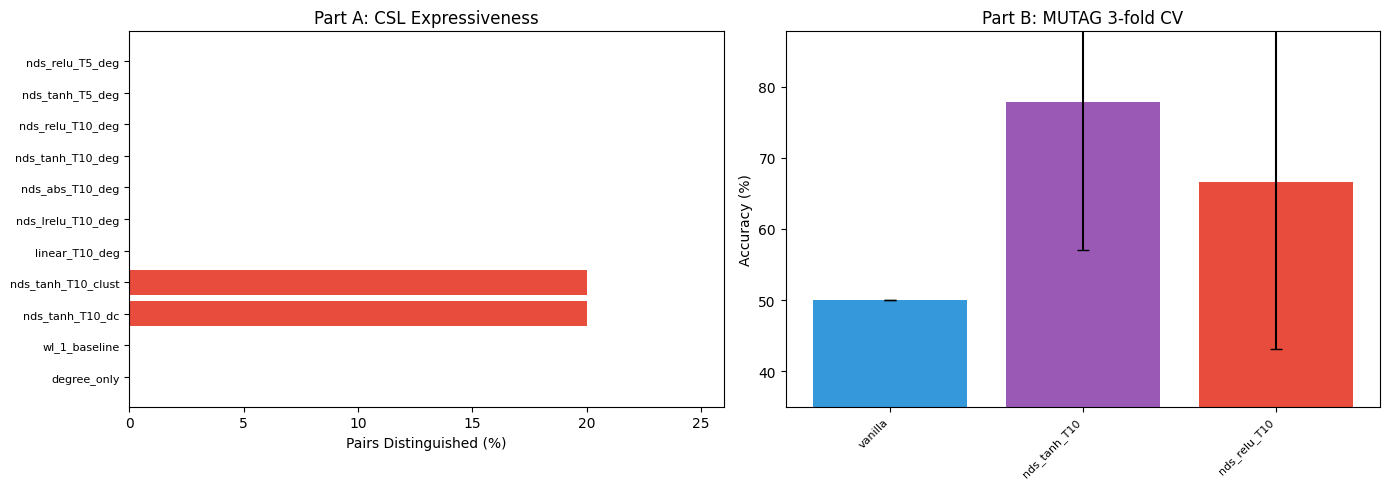

Saved results.png


In [11]:
total_time = time.time() - T0

# ── Part A Summary Table ──
if csl_r:
    print("=" * 60)
    print("PART A: CSL Expressiveness (pairs distinguished / total)")
    print("=" * 60)
    print(f"{'Config':<28} {'Dist':>5} / {'Total':>5}  {'Acc':>7}")
    print("-" * 60)
    for name, sc in csl_r["config_scores"].items():
        print(f"{name:<28} {sc['pairs_distinguished']:>5} / {sc['total_pairs']:>5}  {100*sc['accuracy']:>6.1f}%")
    print()

# ── Part B Summary Table ──
if cls_r:
    print("=" * 60)
    print(f"PART B: MUTAG Classification ({NUM_FOLDS}-fold CV)")
    print("=" * 60)
    for ds, r in cls_r.items():
        print(f"\n{ds} ({r['n_graphs']} graphs, {r['n_classes']} classes)")
        print(f"{'Method':<28} {'Mean Acc':>9} {'Std':>7} {'Folds':>6}")
        print("-" * 55)
        for mn, s in r["method_results"].items():
            print(f"{mn:<28} {100*s['mean_acc']:>8.1f}% {100*s['std_acc']:>6.1f}% {s['n_folds']:>5}")

print(f"\nTotal wall clock: {total_time:.1f}s")

# ── Plots ──
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot A: CSL expressiveness bar chart
if csl_r:
    ax = axes[0]
    names = list(csl_r["config_scores"].keys())
    accs = [csl_r["config_scores"][n]["accuracy"] * 100 for n in names]
    colors = ['#e74c3c' if a > 0 else '#95a5a6' for a in accs]
    bars = ax.barh(range(len(names)), accs, color=colors)
    ax.set_yticks(range(len(names)))
    ax.set_yticklabels(names, fontsize=8)
    ax.set_xlabel("Pairs Distinguished (%)")
    ax.set_title("Part A: CSL Expressiveness")
    ax.set_xlim(0, max(accs) * 1.3 if max(accs) > 0 else 10)
    ax.invert_yaxis()

# Plot B: MUTAG classification accuracy
if cls_r and "MUTAG" in cls_r:
    ax = axes[1]
    mr = cls_r["MUTAG"]["method_results"]
    methods = [m for m in mr.keys() if mr[m]["n_folds"] > 0]
    means = [mr[m]["mean_acc"] * 100 for m in methods]
    stds = [mr[m]["std_acc"] * 100 for m in methods]
    x = range(len(methods))
    cmap = {'gin_vanilla': '#3498db', 'gin_nds_tanh_T10': '#9b59b6',
            'gin_nds_relu_T10': '#e74c3c', 'gin_nds_tanh_T10_clust': '#1abc9c',
            'gin_degree': '#2ecc71', 'gin_linear_diff': '#e67e22'}
    colors = [cmap.get(m, '#95a5a6') for m in methods]
    bars = ax.bar(x, means, yerr=stds, capsize=4, color=colors)
    ax.set_xticks(x)
    ax.set_xticklabels([m.replace('gin_', '') for m in methods], rotation=45, ha='right', fontsize=8)
    ax.set_ylabel("Accuracy (%)")
    ax.set_title(f"Part B: MUTAG {NUM_FOLDS}-fold CV")
    if means:
        ax.set_ylim(max(0, min(means) - 15), min(100, max(means) + 10))

plt.tight_layout()
plt.savefig("results.png", dpi=100, bbox_inches="tight")
plt.show()
print("Saved results.png")